In [ ]:
!shred -u setup_colab.py
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/MINE_4101/setup_colab.py" -O setup_colab.py
!pip install -q https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

- **Taller realizado por Carlos Andrés Salazar Aroca y por Juan Pablo Cano**

In [ ]:
import setup_colab as setup
import pandas as pd
import numpy as np
import pandas_profiling as pp

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.utils import resample

In [ ]:
df = pd.read_excel('data_parcial.xlsx')
df.head()

,CUENTA_TDC,ALTURA_MORA_TDC,HABITO_PAGO_TDC,Edad,ALTURA_MORA_CC,ALTURA_MORA_SBG,ALTURA_MOR_MAX,SALDO_TDC,SALDO_CC,SALDO_SBG,CUPO_TDC,CUPO_CC,CUPO_SBG,SALDO_TOTAL,Y,UTIL_TDC,CUPO_TOTAL,UTIL_TOTAL,SUMA_ALTURA_MORA,MORA_MAX_N_12,MAX_CUPO_TDC_3,MAX_CUPO_TDC_6,MAX_CUPO_TDC_12,NUM_MESES_SIN_MORA_3,NUM_MESES_SIN_MORA_6,NUM_MESES_SIN_MORA_12,estrato,NOMBRE_CIUDAD,DEPARTAMENTO,ACT_ECO,SEXO,NIVEL_EST
0,55202,0,1,38.0,0.0,NaN,0,456563.07,7596420.74,0.0,5750000,8250000.0,0,8052983.81,0,0.079402,14000000.0,0.575213,0,2,5750000,5750000,5750000,2,4,9,3.0,CALI,Valle del,Empleado Privado,M,Profesional
1,92786,0,1,41.0,0.0,NaN,0,0.00,0.00,0.0,3000000,9300000.0,0,0.00,0,0.000000,12300000.0,0.000000,0,0,3000000,3000000,3000000,3,6,12,4.0,BOGOTA,Bogotá D.C,Empleado Privado,F,Profesional
2,62164,6,2,45.0,NaN,NaN,6,1176889.59,0.00,0.0,4200000,0.0,0,1176889.59,0,0.280212,4200000.0,0.280212,6,6,4200000,4200000,4200000,2,4,9,4.0,BOGOTA,Bogotá D.C,Empleado Publico,M,Postgrado
3,21926,0,4,60.0,NaN,NaN,0,1863229.73,0.00,0.0,2800000,0.0,0,1863229.73,0,0.665439,2800000.0,0.665439,0,0,2800000,2800000,2800000,3,6,12,3.0,IBAGUE,Tolima,Pres Servicios,M,Profesional
4,39474,0,5,61.0,0.0,NaN,0,2823939.98,0.00,0.0,2860000,0.0,0,2823939.98,0,0.987392,2860000.0,0.987392,0,0,2860000,2860000,2860000,3,6,12,3.0,CARTAGE,Bolívar,Empleado Privado,M,Técnico/Tecnológico


In [ ]:
df.shape

(5000, 32)

# Perfilamiento
Se encontraron variables altamente correlacionadas entre sí por lo que se decide optar por dejar solo una variable entre estas correlacionadas de manera que se reduzca la complejidad del modelo, para escoger esta variable se tuvo en cuenta la cantidad de valores nulos con los que contaba. Asimismo, se elimina la columna CUENTA_TDC que indica el número de cuenta TDC lo cual viene siendo como un identificador. Se encontró que la columna HABITO_PAGO_TDC cuenta con anomalías en pocas, por lo que se decidió removerlos en lugar de dejarlos.

In [ ]:
pp.ProfileReport(df)

Output hidden; open in https://colab.research.google.com to view.

### Variables categóricas

* HABITO_PAGO_TDC
* Edad
* Y
* NUM_MESES_SIN_MORA_3
* NUM_MESES_SIN_MORA_6
* NUM_MESES_SIN_MORA_12
* estrato
* NOMBRE_CIUDAD
* DEPARTAMENTO
* ACT_ECO
* SEXO 
* NIVEL_EST


## Columnas de interés
Con base al resultado del perfilamiento se seleccionaron las columnas de interés

In [ ]:
def nullValues(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  return missing_data
missing_data = nullValues(df)
missing_data

,Total,Percent
ALTURA_MORA_SBG,4942,0.9884
ALTURA_MORA_CC,4259,0.8518
SEXO,66,0.0132
Edad,66,0.0132
NIVEL_EST,65,0.0130
ACT_ECO,65,0.0130
estrato,65,0.0130
HABITO_PAGO_TDC,63,0.0126
DEPARTAMENTO,23,0.0046
NOMBRE_CIUDAD,23,0.0046


In [ ]:
no_interes = ['CUENTA_TDC','ALTURA_MORA_SBG','ALTURA_MORA_CC',
              'NUM_MESES_SIN_MORA_6','NUM_MESES_SIN_MORA_3',
              'ALTURA_MOR_MAX','SALDO_TDC','SALDO_CC','SALDO_SBG',
              'CUPO_TDC','CUPO_CC','CUPO_SBG','UTIL_TOTAL',
              'SALDO_TOTAL','CUPO_TOTAL','MORA_MAX_N_12','MAX_CUPO_TDC_3',
              'MAX_CUPO_TDC_12','NOMBRE_CIUDAD','MAX_CUPO_TDC_6']
df = df[[col for col in df.columns if col not in no_interes]]
df.head()

,ALTURA_MORA_TDC,HABITO_PAGO_TDC,Edad,Y,UTIL_TDC,SUMA_ALTURA_MORA,NUM_MESES_SIN_MORA_12,estrato,DEPARTAMENTO,ACT_ECO,SEXO,NIVEL_EST
0,0,1,38.0,0,0.079402,0,9,3.0,Valle del,Empleado Privado,M,Profesional
1,0,1,41.0,0,0.000000,0,12,4.0,Bogotá D.C,Empleado Privado,F,Profesional
2,6,2,45.0,0,0.280212,6,9,4.0,Bogotá D.C,Empleado Publico,M,Postgrado
3,0,4,60.0,0,0.665439,0,12,3.0,Tolima,Pres Servicios,M,Profesional
4,0,5,61.0,0,0.987392,0,12,3.0,Bolívar,Empleado Privado,M,Técnico/Tecnológico


In [ ]:
df = df.query("HABITO_PAGO_TDC not in ['A', 'B', 'C', 'D', 'E']")

## Problemas de calidad de los datos
* Había problemas con la cantidad de variables correlacionadas los cuales fueron solucionados eligiendo una variable de todas estas correlacionadas.
* Había variables con un porcentaje superior al 80% de valores nulos (ALTURA_MORA_SBG, ALTURA_MORA_CC)
* La variable que indica si el cliente se pierde por mal comportamiento o no cuenta con un 94% de valores como 0, es decir el 94% de los datos son de clientes que no se pierden por mal comportamiento lo que claramente indica que hay un desbalanceo en el dataset

In [ ]:
def comunes(df):
  max_valu = []
  max_qty = []
  for col in df:
    count = df[col].value_counts()
    max_valu.append(list(count.index)[0])
    max_qty.append(count.max()/count.sum())
  ans = pd.DataFrame({'Comun':max_valu,'P.Apariciones':max_qty},index=list(df.columns))
  return ans
comunes(df)

,Comun,P.Apariciones
ALTURA_MORA_TDC,0,0.864158
HABITO_PAGO_TDC,1,0.389931
Edad,36,0.031199
Y,0,0.948279
UTIL_TDC,0,0.128324
SUMA_ALTURA_MORA,0,0.860938
NUM_MESES_SIN_MORA_12,12,0.582813
estrato,3,0.522120
DEPARTAMENTO,Bogotá D.C,0.440154
ACT_ECO,Empleado Privado,0.418552


# Entendimiento del negocio
Financiera de los Alpes, es una empresa del sector financiero, que ofrece tres productos: TDC (tarjeta de crédito), CC (crédito de consumo o de libre inversión) y SBG (sobregiro). Esa empresa, desea generar estrategias comerciales que permitan reducir el número de clientes perdidos por mal comportamiento crediticio, es decir, clientes con una altura de mora mayor a 90 días en algunos de sus productos. Cuando esta situación ocurre, la entidad bloquea todos los productos de ese cliente y no es posible cambiar su estado, llevando a la pérdida definitiva del cliente. La empresa está buscando reducir la cantidad de clientes perdidos por mal comportamiento crediticio con estrategias basadas en las características de los clientes a perderse.

# Hipótesis de interés
1. La variable dependiente (Y) depende del estrato y del departamento del cliente.
2. El número de meses sin mora en el último año, el sexo y la edad tienen influencia sobre la variable objetivo
3. Los días de mora en la tarjeta de crédito (ALTURA_MORA_TDC), el porcentaje de uso de la tarjeta de crédito (UTIL_TDC) y el estrato hacen que el cliente sea más propenso a perderse por mal comportamiento crediticio

# Hipótesis seleccionada
La hipótesis seleccionada es la hipótesis #3. Los días de mora en la tarjeta de crédito (ALTURA_MORA_TDC), el porcentaje de uso de la tarjeta de crédito (UTIL_TDC) y el estrato hacen que el cliente sea más propenso a perderse por mal comportamiento crediticio, el modelo seleccionado para validarla es random forest pues se cuenta con el software y los recursos computacionales para implementarlo, conocimiento personal y experiencia con este modelo en casos 
similares y con resultados satisfactorios.

In [ ]:
df.dropna(inplace=True)

In [ ]:
X = df.drop("Y", axis=1)
y = df["Y"]

In [ ]:
X.head()

,ALTURA_MORA_TDC,HABITO_PAGO_TDC,Edad,UTIL_TDC,SUMA_ALTURA_MORA,NUM_MESES_SIN_MORA_12,estrato,DEPARTAMENTO,ACT_ECO,SEXO,NIVEL_EST
0,0,1,38.0,0.079402,0,9,3.0,Valle del,Empleado Privado,M,Profesional
1,0,1,41.0,0.000000,0,12,4.0,Bogotá D.C,Empleado Privado,F,Profesional
2,6,2,45.0,0.280212,6,9,4.0,Bogotá D.C,Empleado Publico,M,Postgrado
3,0,4,60.0,0.665439,0,12,3.0,Tolima,Pres Servicios,M,Profesional
4,0,5,61.0,0.987392,0,12,3.0,Bolívar,Empleado Privado,M,Técnico/Tecnológico


In [ ]:
encoder = LabelEncoder()

In [ ]:
X["HABITO_PAGO_TDC"] = X["HABITO_PAGO_TDC"].astype("int")

In [ ]:
X["DEPARTAMENTO"] = encoder.fit_transform(X["DEPARTAMENTO"])

In [ ]:
X["ACT_ECO"] = encoder.fit_transform(X["ACT_ECO"])

In [ ]:
X["SEXO"] = encoder.fit_transform(X["SEXO"])

In [ ]:
X["NIVEL_EST"] = encoder.fit_transform(X["NIVEL_EST"])

In [ ]:
X.head()

,ALTURA_MORA_TDC,HABITO_PAGO_TDC,Edad,UTIL_TDC,SUMA_ALTURA_MORA,NUM_MESES_SIN_MORA_12,estrato,DEPARTAMENTO,ACT_ECO,SEXO,NIVEL_EST
0,0,1,38.0,0.079402,0,9,3.0,17,2,1,3
1,0,1,41.0,0.000000,0,12,4.0,2,2,0,3
2,6,2,45.0,0.280212,6,9,4.0,2,3,1,1
3,0,4,60.0,0.665439,0,12,3.0,16,8,1,3
4,0,5,61.0,0.987392,0,12,3.0,3,2,1,5


# Proceso de Contrucción de Modelo
1. De acuerdo con nuestras hipótesis de negocio, decidimos utilizar las variables "estrato", "ALTURA_MORA_TDC" y "UTIL_TDC" porque son las que más relevancia van a dar a nuestro análisis.
2. Se utilizó un LabelEncoder para transformar variables categóricas de cadenas de caracteres a enteros por categoría. De igual forma, se dividió el dataset usando una partición estratificada.
3. Esta separación es importante porque con una parte hacemos el entrenamiento del dataset y con la otra parte validamos que los resultados del entrenamiento hayan sido buenos. Para cada uno de los datos incluimos todas las variables nombradas en el anterior punto.
4. Para mejorar el pronóstico entrenamos un RandomForest con datos desbalanceados y con datos balanceados con Resampling. Primero, hicimos una búsqueda en cuadrícula cambiando los parámetros "n_estimators", "criterion" y "max_depth" y verificando el recall durante la búsqueda. Luego, hicimos uso de la función de resample para disminuir el número de muestras con clase negativa y hacer ambas clases balanceadas. Hicimos nuevamente la búsqueda en cuadrícula en búsqueda de los mejores hiperparámetros y al final utilizamos el recall como métrica de validación de los mejores hiperparámetros. 

In [ ]:
total = pd.concat([X, y], axis=1)

In [ ]:
total = total[["estrato", "ALTURA_MORA_TDC", "UTIL_TDC", "Y"]]

In [ ]:
X = total.drop("Y", axis=1)
y = total["Y"]

In [ ]:
sss = StratifiedShuffleSplit(test_size=0.2)

In [ ]:
for train_index, test_index in sss.split(X, y):
    pass

In [ ]:
X_train , X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

### Sin Downsampling

In [ ]:
forest_clf = RandomForestClassifier(n_jobs=-1)

In [ ]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = forest_clf.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

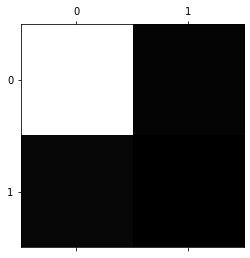

In [ ]:
plt.matshow(conf_matrix, cmap="gray")
plt.show()

In [ ]:
norm_conf_mat = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_mat, 0)

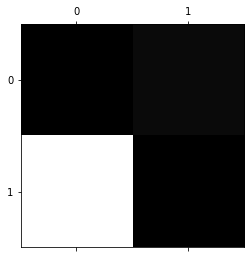

In [ ]:
plt.matshow(norm_conf_mat, cmap="gray")
plt.show()

In [ ]:
recall_score(y_test, y_pred)

0.26

In [ ]:
precision_score(y_test, y_pred)

0.325

In [ ]:
params = {
    "n_estimators": range(100, 201, 50),
    "criterion": ["gini", "entropy"],
    "max_depth": range(50, 101, 10)
}

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(), params, scoring="recall", 
                           n_jobs=-1, verbose=1)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
grid_search.best_score_

0.22243589743589745

In [ ]:
forest_clf = grid_search.best_estimator_

In [ ]:
y_pred = forest_clf.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

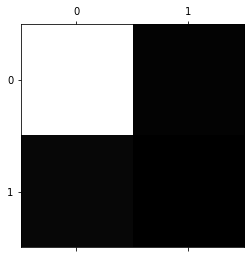

In [ ]:
plt.matshow(conf_matrix, cmap="gray")
plt.show()

In [ ]:
recall_score(y_test, y_pred)

0.26

In [ ]:
precision_score(y_test, y_pred)

0.34210526315789475

### Con Downsampling

In [ ]:
total_train = pd.concat([X_train, y_train], axis=1)

In [ ]:
neg_class = total_train.query("Y==0")
pos_class = total_train.query("Y==1")

In [ ]:
neg_class_downsampled = resample(neg_class, replace=False, 
                                 n_samples=len(pos_class), random_state=1234)

In [ ]:
total_train = pd.concat([pos_class, neg_class_downsampled])

In [ ]:
X_train = total_train.drop("Y", axis=1)
y_train = total_train["Y"]

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(), params, scoring="recall", 
                           n_jobs=-1, verbose=1)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   36.5s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
grid_search.best_score_

0.6714102564102563

In [ ]:
forest_clf = grid_search.best_estimator_

In [ ]:
y_pred = forest_clf.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

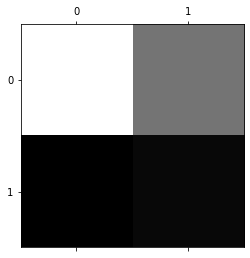

In [ ]:
plt.matshow(conf_matrix, cmap="gray")
plt.show()

In [ ]:
recall_score(y_test, y_pred)

0.7

In [ ]:
precision_score(y_test, y_pred)

0.10736196319018405

## Evaluación del modelo
Creemos que para el negocio es más importante tener un buen recall que una buena precisión pues para el negocio es peor perder un cliente que no se identificó de manera adecuada como cliente propenso a perderse que fallar diciendo que un cliente es un cliente propenso a perderse así no lo sea.

Para el primer modelo obtenido sin GridSearch se obtuvo una precisión y recall muy bajos (22% ambos) lo cual no es para nada una herramienta útil para el negocio.


Para el segundo modelo se hizo GridSearch de manera que se pudiera encontrar la mejor combinación de hiperparámetros para obtener un buen recall. Sin embargo, este recall solo aumentó un 4% con respecto al primer modelo.


Finalmente, se probó haciendo downsampling sobre el conjunto de entrenamiento y se buscó nuevamente con GridSearch la combinación de hiperparámetros que maximizara el recall, el mejor modelo obtenido obtuvo un recall del 70% y una precisión del 10%.

Los resultados obtenidos, a pesar de que la métrica a maximizar es el recall, no son del todo buenos pues, para el mejor modelo obtenido (el último), una precisión tan baja no es bien compensada por el recall obtenido y además implica que el modelo es propenso a presentar muchos falsos positivos.

## Resultados del Negocio en el ejercicio
- Los resultados del ejercicio se podrían utilizar en el negocio para descartar las características que tiene un cliente propenso a perderse y más bien establecerlas como las características que tiene un cliente NO propenso.
- El modelo obtenido puede ser usado como herramienta. Sin embargo, es muy probable que se clasifiquen demasiados clientes no propensos a perderse como clientes propensos a perderse.
- Dado que hubo un alto recall, es muy posible que un cliente con buenas estadísticas sea clasificado como propenso a perderse, lo que podría generar molestias en varios buenos clientes de la agencia. Por lo tanto, es necesario que haya mejor cantidad de datos para que haya una precisión y una cobertura en los resultados de nuestro modelos.